# Trabalhando com séries temporais e realizando predições de venda

Séries temporais são conjuntos de dados ordenados no tempo, como dados de vendas e preços de ações, por exemplo. O conhecimento sobre séries temporais vem bastante ao caso quando falamos de predições. Esse tipo de análise é bastante importante e vem sendo cada vez mais utilizado em diversos contextos.

Nesse notebook, empregaremos alguns conceitos sobre séries temporais para realizar a predição de preços de abacate (em dólares). Apesar de ser um exemplo lúdico, ele pode servir como uma analogia para situações reais, como a análise de preços de empresas concorrentes, em um caso empresarial, por exemplo.

Faremos esse exercício de predição utilizando Python (e algumas bibliotecas importantes) e um conjunto de dados disponível gratuitamente no [Kaggle](https://www.kaggle.com/mathurinache/avocado-augmented "Avocado prices (augmented)"), que contém dados de venda de abacate nos Estados Unidos entre 2015 e 2018.

## Explorando o conjunto de dados

Antes de qualquer coisa, é importante entendermos sobre o conjunto de dados com o qual iremos trabalhar. 

Primeiramente, iremos importar as bibliotecas e funções necessárias, e carregar nosso conjunto de dados por completo.

In [2]:
# importando as bibliotecas e funções utilizadas no código
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
plt.rcParams['agg.path.chunksize'] = 10000

In [3]:
#definição de cores para os gráficos

color_list = ['#1481c1', '#f12553']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [4]:
# leitura do arquivo csv

datapath = './Augmented_avocado.csv' #fonte: https://www.kaggle.com/mathurinache/avocado-augmented
df = pd.read_csv(datapath)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df.head()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
2015-01-04,28.110237,1.067238,8.694930e+05,729092.893820,25351.679256,660.521162,1.004203e+05,774572.742844,4584.245287,77.808862,conventional,2015.996867,Denver
2015-01-04,1.572266,1.182851,3.392160e+05,-7126.278994,6343.190422,1744.733838,9.164930e+04,52417.214688,64292.280389,-81.501851,conventional,2017.021296,RichmondNorfolk
2015-01-04,27.698464,1.010103,1.003913e+06,135920.046923,-10453.171511,38183.923925,1.283991e+06,33320.804223,32274.971967,23.954434,conventional,2016.015915,GrandRapids
2015-01-04,23.205972,2.037675,4.684201e+04,-10791.423866,-11870.226399,130.504001,5.344330e+03,-10284.410798,4903.903353,-71.976916,organic,2014.998154,NorthernNewEngland
2015-01-04,43.915310,2.631752,-2.936871e+04,-8290.207744,-29400.868245,825.060689,-5.818334e+03,1083.105122,1356.634473,-116.180783,organic,2016.011704,WestTexNewMexico


Temos várias informações nesse conjunto de dados que não iremos utilizar para nossa análise. Vamos então limpar esse dataframe e ficar apenas com os dados da média dos preços. 

Também temos vários valores para um mesmo dia, que variam de acordo com a localização, mas essa relação não é de nosso interesse. Então iremos fazer a média desses dados, agrupando-os pela data.

Assim, obtemos a base disposta abaixo, que utilizaremos para fazer a predição de vendas.

In [5]:
df = df.groupby('Date')['AveragePrice'].mean().to_frame()
df.head(10)

,AveragePrice
Date,
2015-01-04,1.393442
2015-01-11,1.380804
2015-01-18,1.452548
2015-01-25,1.279154
2015-02-01,1.327422
2015-02-08,1.451592
2015-02-15,1.322849
2015-02-22,1.382528
2015-03-01,1.342962


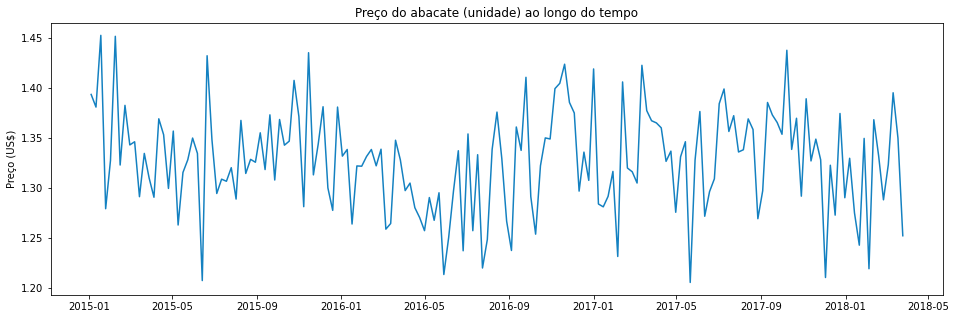

In [6]:
plt.figure(figsize=(16, 5))
plt.plot(df)
plt.ylabel('Preço (US$)')
plt.title('Preço do abacate (unidade) ao longo do tempo')
plt.savefig('avocado-price.png')

### Separando a base de treino

Como em qualquer projeto de machine learning, é interessante que o conjunto de dados seja dividido entre uma base de treino e uma base de teste, para validarmos a eficácia do modelo.

Então, iremos formar uma base de treino com os 152 primeiros valores do nosso conjunto inicial (aprox. 90%) e o restante deixaremos em uma base de teste.

A seguir podemos ver o resultado gráfico dessa separação.

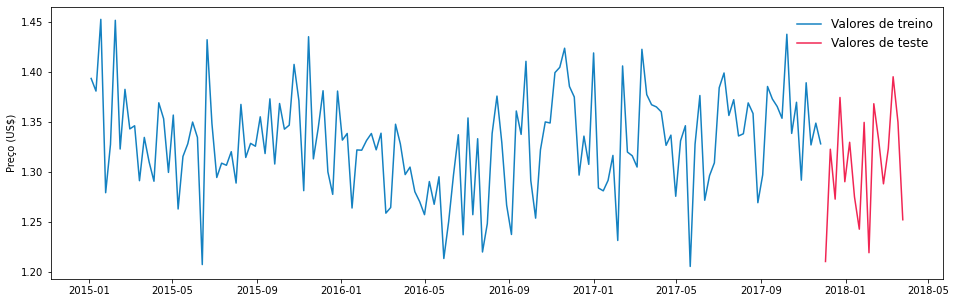

In [7]:
train = df.iloc[:152,0].to_frame()
test = df.iloc[152:169,0].to_frame()

plt.figure(figsize=(16, 5))
plt.plot(train)
plt.plot(test)
plt.legend(['Valores de treino','Valores de teste'], fontsize='large',frameon=False)
plt.ylabel('Preço (US$)')
plt.savefig('train-test.png')

### Analisando a série temporal

As séries temporais possuem diversas características que podem afetar a modelagem, como a sazonalidade, a tendência e a estacionariedade. Se elas forem presentes no conjunto de dados, será necessário fazer alguns ajustes antes de aplicar a modelagem.

No entanto, não conseguimos avaliar essas características no nosso conjunto de dados apenas com a representação gráfica acima. Então, utilizaremos o recurso visual da decomposição sazonal e o teste de Dickey-Fuller, que nos indicará estatisticamente se nossa série é estacionária ou não. Para isso, utilizaremos as funções **seasonal_decompose()** e **adfuller()** da biblioteca statsmodels.

Abaixo, temos a decomposição sazonal do nosso conjunto de dados. Nesses gráficos, conseguimos observar tanto a tendência quanto a sazonalidade da série.

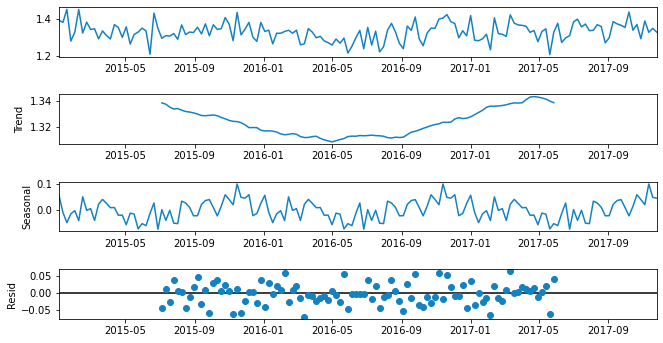

In [8]:
decomposition = sm.tsa.seasonal_decompose(train, model='additive')
fig = decomposition.plot()
fig.set_size_inches(10,5)
plt.savefig('seasonal_decompose.png')
plt.show()

Observando a figura anterior, é possível notar uma pequena tendência de queda e vemos uma leve sazonalidade também. No entanto, é importante termos resultados mais objetivos e diretos para analisar se nossa base está adequada para a modelagem.

Para isso, utilizaremos o teste de Dickey-Fuller. Se obtermos um p-value inferior ao nível de significância adotado, rejeitamos a hipótese de que a série possui raiz unitária e, portanto, temos que ela é estacionária.

In [9]:
adf_results = adfuller(train)

print('Teste Dickey-Fuller: %f' % adf_results[0])
print('p-value: %f' % adf_results[1])
print('Valores críticos:')
for key, value in adf_results[4].items():
    print('\t%s: %.4f' % (key, value))    

Teste Dickey-Fuller: -4.163590
p-value: 0.000759
Valores críticos:
	1%: -3.4753
	5%: -2.8813
	10%: -2.5773


Esses resultados nos mostram que, mesmo a um nível de significância de 1% (o menor dos mais comumente utilizados), ainda rejeitaremos a hipótese da raiz unitária. Deste modo, concluímos que o conjunto de dados é estacionário, e podemos partir para a modelagem.

### Modelagem

Uma das formas mais comuns de modelar séries temporais é com o modelo de médias móveis auto regressivas e integradas, mais popularmente conhecido como ARIMA. Esse modelo é calculado com base em parâmetros p,d e q, definidos a seguir:
* p: refere-se à ordem do modelo auto regressivo;
* d: refere-se ao grau de diferenciação do modelo;
* q: refere-se à ordem do modelo de média móvel.

A diferenciação de um modelo é empregada para torná-lo estacionário. Como no nosso caso já estamos trabalhando com um modelo estacionário, não há necessidade de aplicar a diferenciação.

Então, nosso modelo ARIMA transforma-se em um modelo ARMA, já que não teremos o parâmetro d.

Como próximo passo, vamos analisar a auto correlação do modelo, utilizando as funções  **plot_acf()** e **plot_pacf()** da biblioteca statsmodel, que geram os gráficos a seguir.


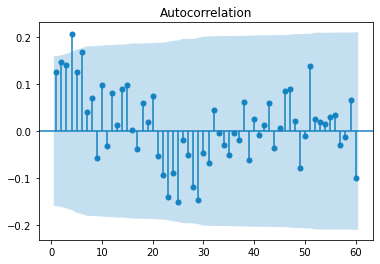

In [10]:
plot_acf(train, lags=60, zero=False)
plt.savefig('plot_acf.png')
plt.show()

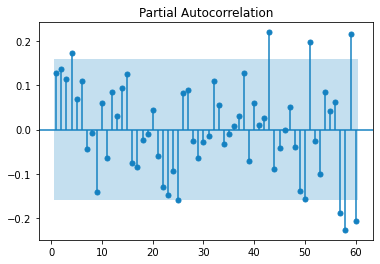

In [11]:
plot_pacf(train, lags=60, zero=False)
plt.savefig('plot_pacf.png')
plt.show()

Os gráficos indicam que há correlação se existem pontos fora da região azul. Observando nosso resultado, vemos que não existe uma correlação muito discrepante entre os lags. Deste modo, também não iremos considerar o parâmetro p do modelo ARMA.

Sem os parâmetros p e d, nos resta uma modelagem por média móvel. Vamos implementá-la a seguir.
Para entendermos o efeito da média móvel, vamos aplicá-la na nossa base de teste, considerando uma média das últimas 4 semanas. A biblioteca pandas já fornece a função **rolling()** que facilita esse cálculo e nos permite gerar o gráfico a seguir.

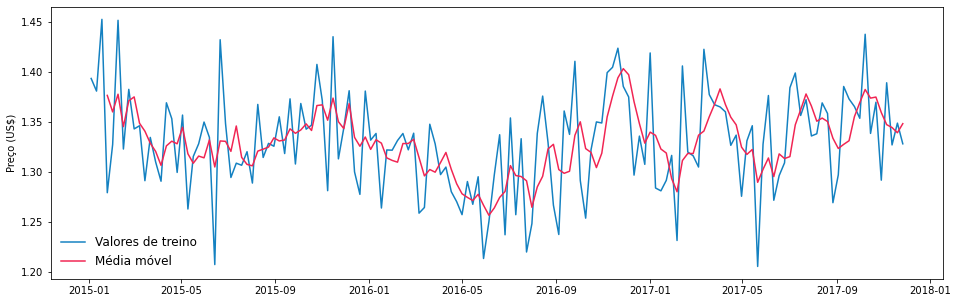

In [12]:
plt.figure(figsize=(16, 5))
plt.plot(train)
plt.plot(train.rolling(4).mean())
plt.legend(['Valores de treino','Média móvel'],fontsize='large',frameon=False)
plt.ylabel('Preço (US$)')
plt.savefig('rolling_avg.png')

No entanto, nosso objetivo é fazer com que o modelo preveja os dados futuros. Vamos aplicar a média móvel na base de teste para validar essa modelagem.

Note que os primeiros valores consideram os dados da base de treino, já que o cálculo é feito com base no histórico. Conforme vamos construindo os dados de previsão, eles passam a ser usados para o cálculo da média móvel.

In [13]:
## aplicando a modelagem de médias móveis na base de teste

# criação de uma função para calcular a média móvel com base nos últimos n valores
def moving_average(n, train_data, test_data):
    data = [train_data.iloc[i,0] for i in range(len(train_data))]
    predicted = []
    for j in range(len(test_data)):
        mean = np.mean(data[-n:])
        prices = test_data.iloc[j,0]
        predicted.append(mean)
        data.append(prices)
    return predicted

# criação de uma coluna na base de teste contento os resultados da predição
test['Predicted'] = moving_average(4, train, test) 

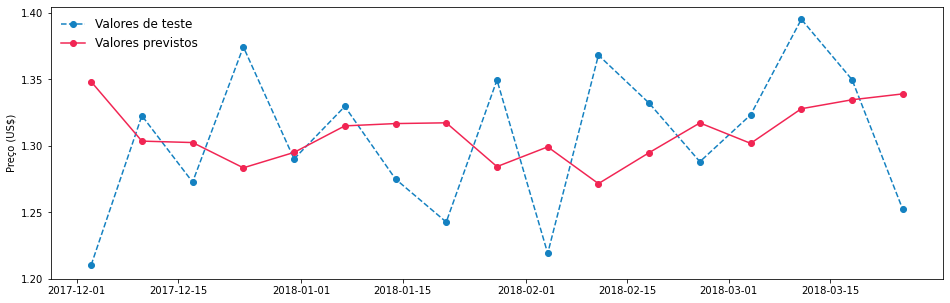

In [14]:
plt.figure(figsize=(16, 5))
plt.plot(test.AveragePrice, 'o--')
plt.plot(test.Predicted, 'o-')
bottom, top = plt.ylim()
plt.yticks(np.round(np.arange(bottom, top, step=0.05),2))
plt.legend(['Valores de teste','Valores previstos'],frameon=False,fontsize='large')
plt.ylabel('Preço (US$)')
plt.savefig('predicted.png')

A partir da figura, podemos ver que o resultado da predição não foge muito dos valores de teste, que de fato ocorreram. Porém, é interessante validar a eficácia do modelo de uma maneira menos qualitativa. 

Para isso, calcularemos o erro médio absoluto (mean absolute error - MAE) e o erro percentual absoluto médio (mean absolute percentage error - MAPE). Utilizando essas métricas, teremos maior clareza do comportamento do modelo e saberemos como podemos aplicá-lo.

In [17]:
mape = np.mean(abs(test.AveragePrice.values - test.Predicted.values)/test.AveragePrice.values)*100
mae = mean_absolute_error(test.AveragePrice,test.Predicted)
print('MAPE: %.2f%%' % mape)
print('MAE: %.4f' % mae)

MAPE: 4.15%
MAE: 0.0537


No nosso modelo, obtemos um MAE de aproximadamente US$\$$ 0,05 e um MAPE de 4,15% sobre o valor real, um resultado bastante satisfatório, considerando que o preço unitário do abacate é baixo, em valores absolutos.

Fazendo uma analogia com uma possível aplicação real, vamos supor que somos vendedores de abacate e o modelo está nos mostrando dados do preço de nosso concorrente. 

Caso o modelo preveja que nosso concorrente estabeleça um preço de US$\$$ 1,30 na próxima semana, a partir dos erros calculados, pode-se esperar que o preço de fato esteja entre US$\$$ 1,24 e US$\$$ 1,35. Deste modo, ao conhecermos a possibilidade do preço aumentar, podemos fazer uma promoção e ganhar a preferência dos clientes.

É importante ressaltar que, nesta abordagem, fizemos uma análise geral de todas as localidades contidas na base de dados. Outra possibilidade seria manter a separação original e treinar diversos modelos para obter previsões de preço da concorrência por região.